In [33]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

from datasets import NetflixData, NetflixGenreData
from utils import read_cache, sample
from generators import DiagBooleanMatrix, ArbiBooleanMatrix
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# target size

n_rows = 100
n_cols = 50

In [35]:
cache_path = "D:/OneDrive - Singapore Management University/cache/netflix_data_small.pickle"
X, factor_info = read_cache(cache_path)

idx_u, _, X = sample(X, axis=0, n_samples=n_rows, seed=3080)
idx_v, _, X = sample(X, axis=1, n_samples=n_cols, seed=4060)

nfg_data = NetflixGenreData(small=True)
_, _, Z = sample(nfg_data.X, idx=idx_v, axis=1)

display(X)
display(Z)

[I] Sampling to size 100
[I]   sampling seed    : 3080
[I]   sampling from    : (9980, 3362)
[I]            to      : (100, 3362)
[I] Sampling to size 50
[I]   sampling seed    : 4060
[I]   sampling from    : (100, 3362)
[I]            to      : (100, 50)
[I] Sampling with given indices
[I]   sampling from    : (22, 3362)
[I]            to      : (22, 50)


<100x50 sparse matrix of type '<class 'numpy.int32'>'
	with 39 stored elements in Compressed Sparse Row format>

<22x50 sparse matrix of type '<class 'numpy.intc'>'
	with 139 stored elements in Compressed Sparse Row format>

[I] m            : 100
[I] n            : 50
[I] k            : 4
[I] overlap_flag : False
[I] size_range   : [0.25 0.75 0.25 1.  ]
[I] seed         : 2023
[I] noise        : [0.4  0.02]
[I] seed         : 1024
[I] Using RandomState.


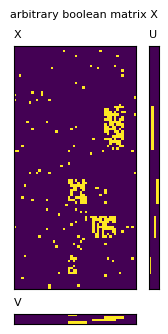

[I] m            : 20
[I] n            : 50
[I] k            : 4
[I] overlap      : [0.2 0.1 0.2 0.1]
[I] seed         : 1997
[I] seed         : 2023
[I] Using RandomState.
[I] Using RandomState.
[I] noise        : [0.1 0.1]
[I] seed         : 1024
[I] Using RandomState.


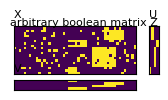

In [36]:
# generate arbitrary Boolean matrix (X)

k=4
overlap_flag=True
noise=[0.4, 0.02]
size_range=[0.25, 0.75, 0.25, 1.0]

X = ArbiBooleanMatrix(m=n_rows, n=n_cols, k=k, overlap_flag=False, size_range=size_range)
X.generate(seed=2023) # if no seed assigned, use time instead
X.add_noise(noise=noise, seed=1024)
X.show_matrix(title='arbitrary boolean matrix X')

# generate arbitrary Boolean matrix (Z)

k=4
overlap=[0.2, 0.1, 0.2, 0.1]
noise=[0.1, 0.1]

Z = DiagBooleanMatrix(m=20, n=n_cols, k=k, overlap=overlap)
Z.generate(seed=1997)
Z.shuffle_factors(seed=2023)
Z.V = X.V # replace one factor
Z.boolean_matmul()
Z.add_noise(noise=noise, seed=1024)
Z.show_matrix(title="arbitrary boolean matrix Z")

X, Z = X.X, Z.X

In [37]:
# from datasets import RatioSplit, NoSplit
# # X_split = RatioSplit(X=X, test_size=0.2, seed=1000)
# X_split = NoSplit(X)

[I] k            : 5
[I] tau          : 0.2
[I] weights      : [0.7, 0.3]
[I] k            : 5
[I] tau          : 0.2
[I] weights      : [0.7, 0.3]
[I] display      : True
[W] Missing validation data.


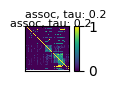

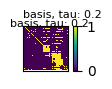

[I] display      : False
[W] Missing validation data.


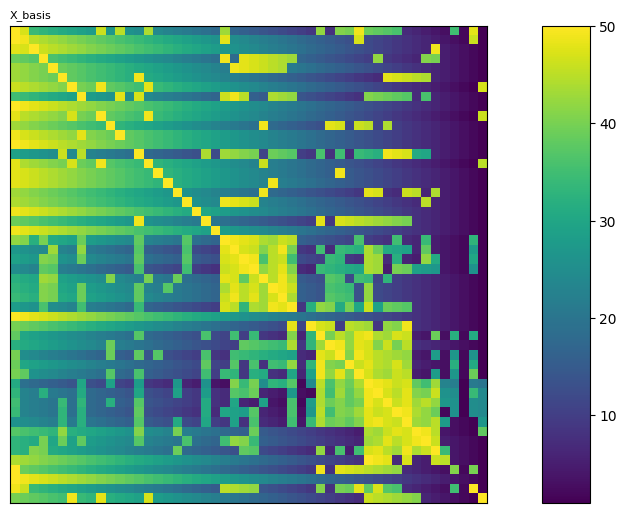

[I] k            : 5
[I] tau          : 0.7
[I] weights      : [0.7, 0.3]
[I] k            : 5
[I] tau          : 0.7
[I] weights      : [0.7, 0.3]
[I] display      : True
[W] Missing validation data.


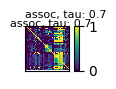

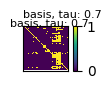

[I] display      : False
[W] Missing validation data.


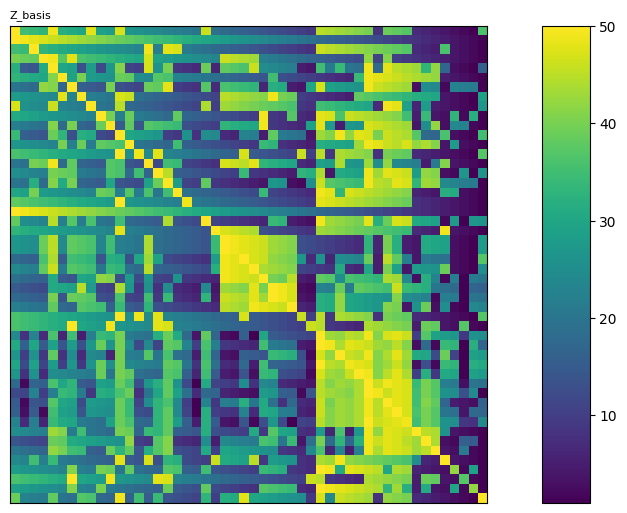

: 

In [38]:
from models import Asso, AssoQuant
from utils import show_matrix, check_sparse

k = 5
tau = 0.2
w = [0.7, 0.3]

asso = Asso(k=k, tau=tau, w=w) # k, w don't matter
aq = AssoQuant(k=k, tau=tau, w=w) # k, tau, w don't matter

asso._fit_prepare(X_train=X, display=True)
X_assoc = check_sparse(asso.assoc, sparse=False)
X_basis_asso = check_sparse(asso.basis, sparse=False)
# settings = [(X_basis, [0, 0], 'X_basis ASSO')]
# show_matrix(settings=settings, colorbar=True)

aq._fit_prepare(X_train=X, display=False)
X_basis = aq.basis
settings = [(n_cols - aq.basis + 1, [0, 0], 'X_basis')]
show_matrix(settings=settings, colorbar=True, scaling=0.5)

# Z

tau = 0.7

asso = Asso(k=k, tau=tau, w=w) # k, w don't matter
aq = AssoQuant(k=k, tau=tau, w=w) # k, tau, w don't matter

asso._fit_prepare(X_train=Z, display=True)
Z_assoc = check_sparse(asso.assoc, sparse=False)
Z_basis_asso = check_sparse(asso.basis, sparse=False)
# settings = [(Z_basis, [0, 0], 'Z_basis ASSO')]
# show_matrix(settings=settings, colorbar=True)

aq._fit_prepare(X_train=Z, display=False)
Z_basis = aq.basis
settings = [(n_cols - aq.basis + 1, [0, 0], 'Z_basis')]
show_matrix(settings=settings, colorbar=True, scaling=0.5)

C:\Users\nieht\AppData\Local\Temp\ipykernel_1248\2931921843.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm))


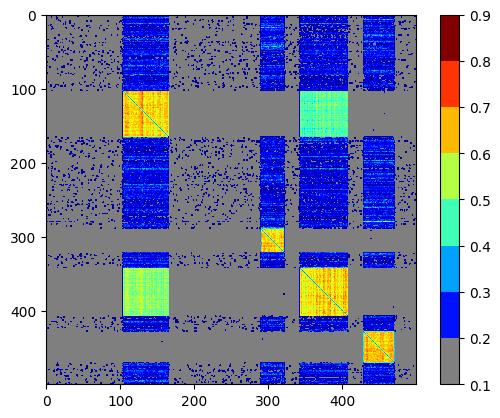

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_basis(assoc, steps):
    assoc = np.asarray(assoc)
    threshold = np.linspace(start=0, stop=1, num=steps, endpoint=False)[1:]
    basis = np.zeros(shape=assoc.shape)
    for t in threshold:
        basis = basis + (assoc > t) * 1
    for i in range(n_cols):
        basis[i, i] = 0
    

    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[0] = (.5, .5, .5, 1.0)
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    norm = mpl.colors.BoundaryNorm(threshold, cmap.N)

    plt.imshow(basis, cmap=cmap)#plt.cm.jet)
    plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm))
    plt.show()

    # show_matrix(settings=[(basis, [0, 0], 'basis')], colorbar=True)

plot_basis(X_assoc, 10)

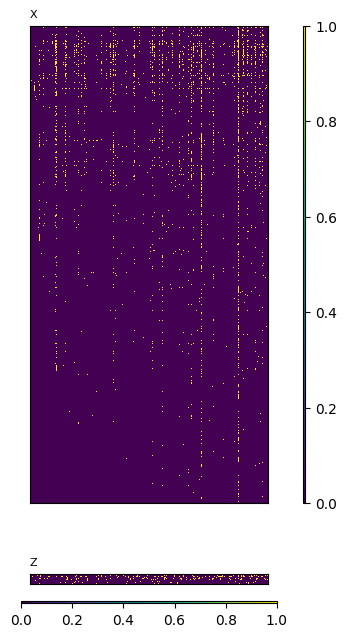

In [9]:
from utils import to_dense
settings = [(to_dense(X), [0, 0], 'X'), (to_dense(Z), [2, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, scaling=0.5)

In [33]:
from utils import dot
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool

def overlap_only(i, j):
    '''overlap of i-th row in X with j-th row in Z
    '''

    score = np.zeros(n_col)

    for t in range(n_col):
        X_row = X_basis[i]
        Z_row = Z_basis[j]
        score[t] = sum(Z_row[X_row<=(t+1)]<=(t+1))
        score[t] = score[t] / (t+1)
        # score[t] = score[t] * X_assoc[i, X_row==(t+1)] # * Z_assoc[i, Z_row==(t+1)]
    return score

def overlap(i, j):
    '''overlap of i-th row in X with j-th row in Z
    '''

    score = np.zeros(n_col)

    for t in range(n_col):
        X_row = X_basis[i]
        Z_row = Z_basis[j]
        score[t] = sum(Z_row[X_row<=(t+1)]<=(t+1))
        score[t] = score[t] / (t+1)
        score[t] = score[t] * X_assoc[i, X_row==(t+1)] # * Z_assoc[i, Z_row==(t+1)]
    return score

def overlap_X_assoc(i, j):
    '''overlap of i-th row in X with j-th row in Z
    '''

    score = np.zeros(n_col)

    for t in range(n_col):
        X_row = X_basis[i]
        Z_row = Z_basis[j]
        score[t] = sum(Z_row[X_row<=(t+1)]<=(t+1))
        score[t] = score[t] / (t+1)
        score[t] = 1 * X_assoc[i, X_row==(t+1)] # * Z_assoc[i, Z_row==(t+1)]
    return score

def overlap_Z_assoc(i, j):
    '''overlap of i-th row in X with j-th row in Z
    '''

    score = np.zeros(n_col)

    for t in range(n_col):
        X_row = X_basis[i]
        Z_row = Z_basis[j]
        score[t] = sum(Z_row[X_row<=(t+1)]<=(t+1))
        score[t] = score[t] / (t+1)
        score[t] = 1 * Z_assoc[i, Z_row==(t+1)]
    return score

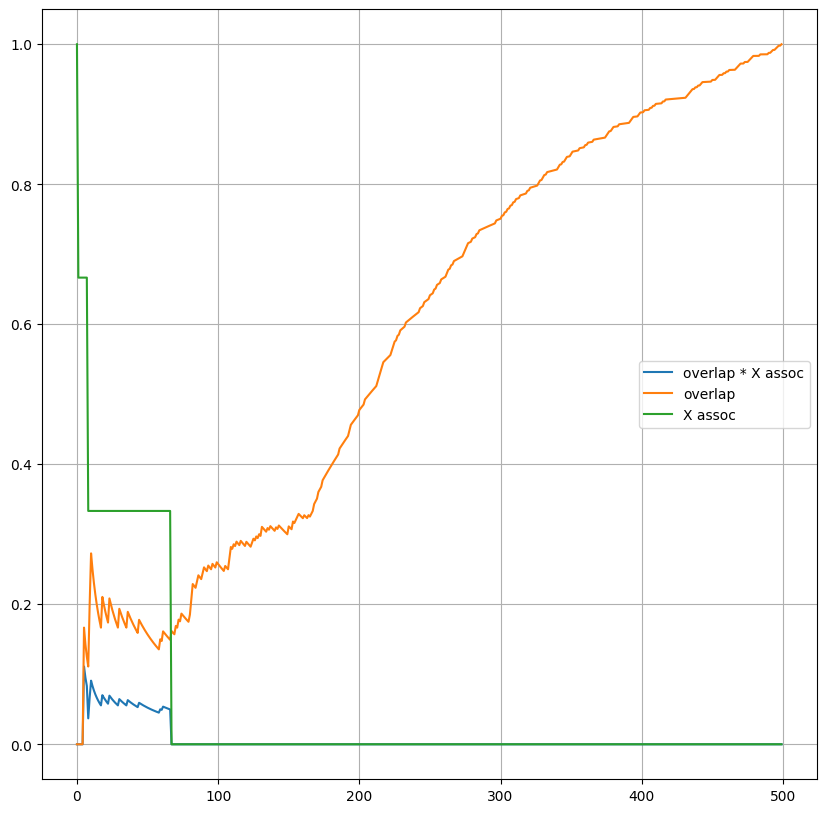

In [48]:
# inconsistant
i = 400 # i-th basis from X_basis
j = 30 # j-th basis from Z_basis

# show_matrix(settings=[(to_dense(X_basis_asso), [0, 0], f'row {i}')])
# display(X[:, i].sum())
# show_matrix(settings=[(to_dense(Z_basis_asso), [0, 0], f'row {i}')])
# display(Z[:, i].sum())

covers = overlap(i, j)
plt.plot(np.arange(n_col), covers);

covers = overlap_only(i, j)
plt.plot(np.arange(n_col), covers);

covers = overlap_X_assoc(i, j)
plt.plot(np.arange(n_col), covers);

covers = overlap_Z_assoc(i, j)
# plt.plot(np.arange(n_col), covers);

plt.legend(['overlap * X assoc', 'overlap', 'X assoc', 'Z assoc'])

plt.grid()

In [19]:
# self correlation
def overlap_self(i, j):
    '''overlap of i-th row in X with j-th row in Z
    '''

    score = np.zeros(n_col)

    for t in range(n_col):
        X_row = X_basis[i]
        Z_row = X_basis[j]
        score[t] = sum(Z_row[X_row<=(t+1)]<=(t+1))
        score[t] = score[t] / (t+1)
        score[t] = score[t] * X_assoc[i, X_row==(t+1)] # * Z_assoc[i, Z_row==(t+1)]
    return score

import matplotlib.pylab as pl

plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.figure(dpi=1200)

colors = pl.cm.copper(np.linspace(0, 1, n_col))

covers_self = np.zeros((n_col, n_col))
for j in tqdm(range(n_col)):
    covers_self[:, j] = overlap_self(i, j)

100%|██████████| 500/500 [00:08<00:00, 59.68it/s]


<Figure size 12000x12000 with 0 Axes>

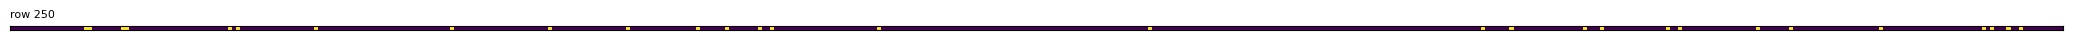

<1x500 sparse matrix of type '<class 'numpy.intc'>'
	with 29 stored elements in Compressed Sparse Row format>

100%|██████████| 500/500 [00:00<00:00, 5585.45it/s]


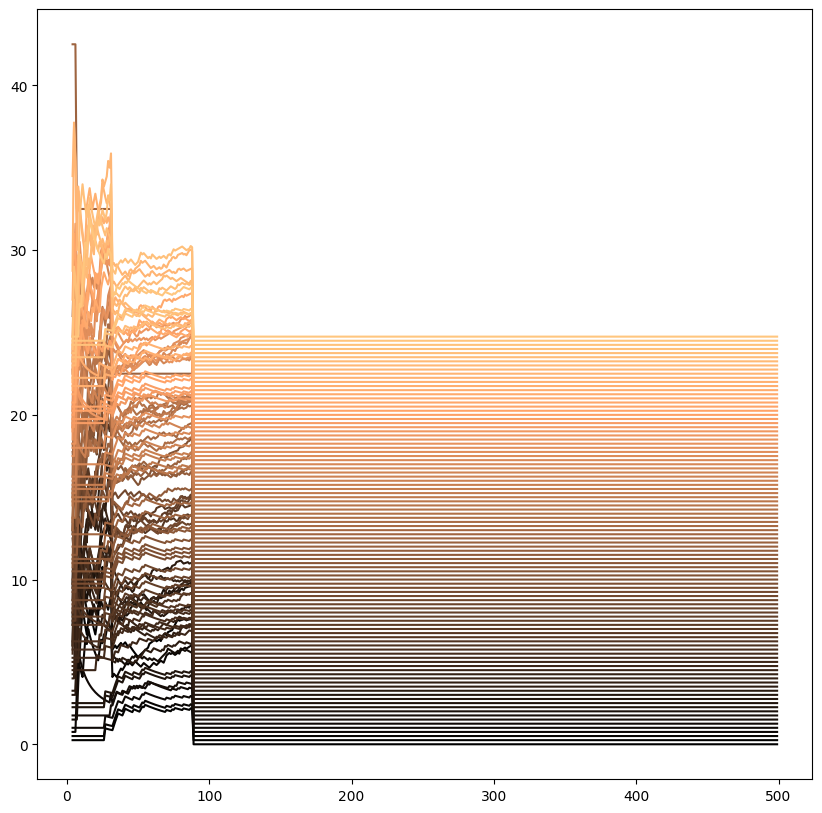

In [20]:
for j in tqdm(range(n_col)):
    if j % 5 == 0:
        pl.plot(np.arange(4, 500),  40 * covers_self[4:500, j] + 0.05 * j, color=colors[j])

In [15]:
# all
import matplotlib.pylab as pl

plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.figure(dpi=1200)

colors = pl.cm.copper(np.linspace(0, 1, n_col))

covers = np.zeros((n_col, n_col))
for j in tqdm(range(n_col)):
    covers[:, j] = overlap(i, j)



100%|██████████| 500/500 [00:08<00:00, 62.41it/s]


<Figure size 12000x12000 with 0 Axes>

100%|██████████| 500/500 [00:00<00:00, 9033.72it/s]


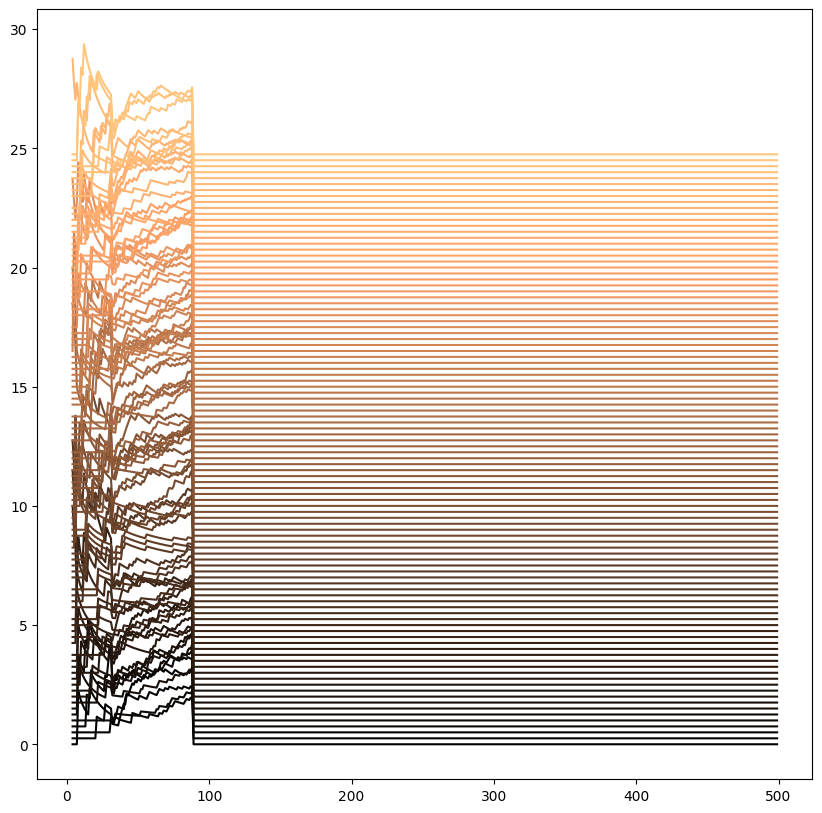

In [18]:
for j in tqdm(range(n_col)):
    if j % 5 == 0:
        pl.plot(np.arange(4, 500),  40 * covers[4:500, j] + 0.05 * j, color=colors[j])

100%|██████████| 500/500 [00:00<00:00, 3493.57it/s]


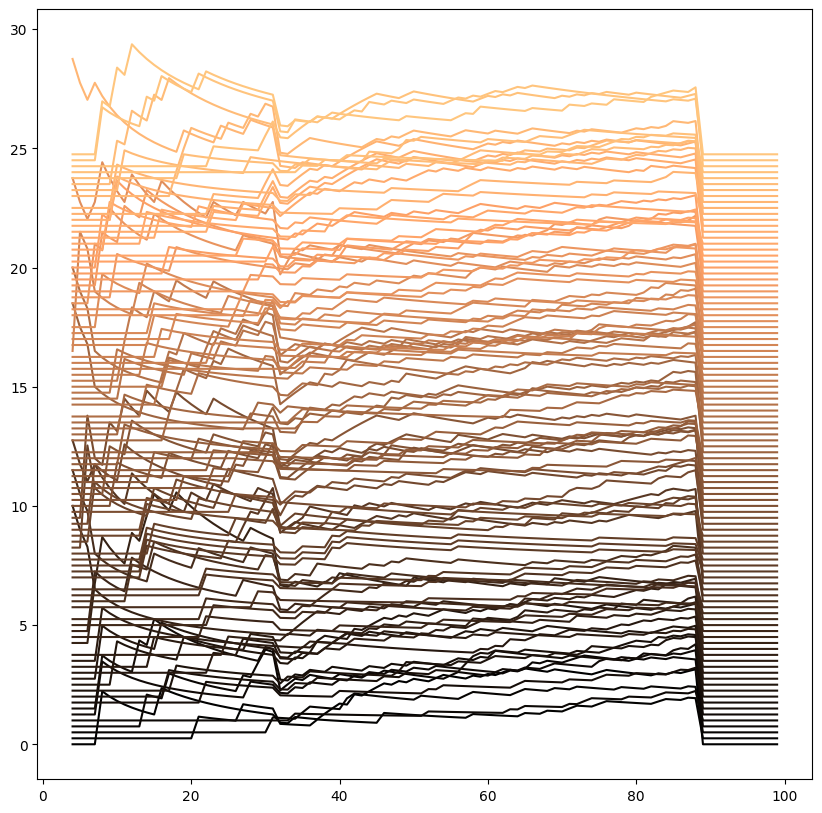

In [16]:
for j in tqdm(range(n_col)):
    if j % 5 == 0:
        pl.plot(np.arange(4, 100),  40 * covers[4:100, j] + 0.05 * j, color=colors[j])